# Improved Revenue Prediction
This notebook adds advanced feature engineering and uses LightGBM with hyperparameter tuning.

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
# import all the lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer, RobustScaler
import joblib
import pickle as pkl


In [2]:
path = r"D:\large_sales_revenue_prediction_data.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.head()

,product_type,marketing_channel,season,ad_budget,unit_price,units_sold,sales_revenue
0,Camera,Email,Fall,10392.45,738.535810,15,11078.037145
1,Smartphone,Search Engine,Winter,10371.33,771.818489,20,15436.369776
2,Tablet,Social Media,Winter,14157.72,532.614592,38,20239.354489
3,Headphones,Email,Winter,2729.71,88.608061,36,3189.890211
4,Laptop,Affiliate,Winter,13153.34,1039.225714,16,16627.611425


In [5]:
product_type_target_encoding = df.groupby('product_type')['sales_revenue'].mean().to_dict()

# Step 2: Map the product_type to its corresponding mean sales_revenue
df['product_type_encoded'] = df['product_type'].map(product_type_target_encoding)

# Step 3: (Optional) Drop the original product_type column if you don't need it
df = df.drop(columns=['product_type'])


In [6]:
label_encoder = LabelEncoder()

# Fit and transform the 'season' column
df['season_encoded'] = label_encoder.fit_transform(df['season'])

In [7]:
marketing_channel_encoded = pd.get_dummies(df['marketing_channel'], prefix='marketing_channel',dtype='int')

# Merge the encoded columns back to the original dataframe
df = pd.concat([df, marketing_channel_encoded], axis=1)

# (Optional) Drop the original 'marketing_channel' column
df = df.drop(columns=['marketing_channel'])

In [8]:
df.head()

,season,ad_budget,unit_price,units_sold,sales_revenue,product_type_encoded,season_encoded,marketing_channel_Affiliate,marketing_channel_Direct,marketing_channel_Email,marketing_channel_Search Engine,marketing_channel_Social Media
0,Fall,10392.45,738.535810,15,11078.037145,11252.065600,0,0,0,1,0,0
1,Winter,10371.33,771.818489,20,15436.369776,11123.076477,3,0,0,0,1,0
2,Winter,14157.72,532.614592,38,20239.354489,11305.338169,3,0,0,0,0,1
3,Winter,2729.71,88.608061,36,3189.890211,11439.296352,3,0,0,1,0,0
4,Winter,13153.34,1039.225714,16,16627.611425,11161.857041,3,1,0,0,0,0


In [9]:
df.drop('season',axis=1,inplace=True)

In [10]:
correaltion=df.corr()

<Axes: >

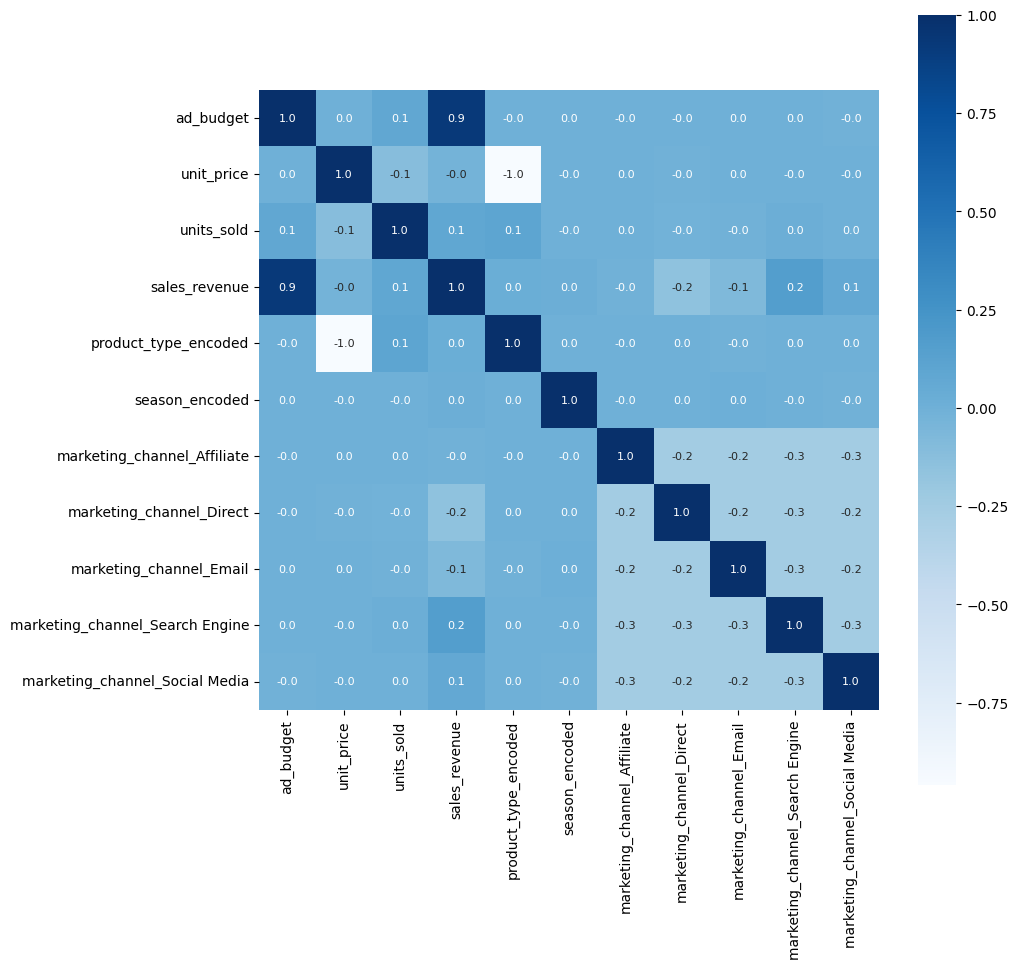

In [11]:

correlation=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(
    correlation,
    cbar=True,
    square=True,
    fmt='.1f', 
    annot=True,
    annot_kws={'size': 8},
    cmap='Blues'
)


In [12]:
df.head()

,ad_budget,unit_price,units_sold,sales_revenue,product_type_encoded,season_encoded,marketing_channel_Affiliate,marketing_channel_Direct,marketing_channel_Email,marketing_channel_Search Engine,marketing_channel_Social Media
0,10392.45,738.535810,15,11078.037145,11252.065600,0,0,0,1,0,0
1,10371.33,771.818489,20,15436.369776,11123.076477,3,0,0,0,1,0
2,14157.72,532.614592,38,20239.354489,11305.338169,3,0,0,0,0,1
3,2729.71,88.608061,36,3189.890211,11439.296352,3,0,0,1,0,0
4,13153.34,1039.225714,16,16627.611425,11161.857041,3,1,0,0,0,0


In [13]:
X = df.drop(['sales_revenue'], axis=1)
y = df['sales_revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = RobustScaler()

# Fit scaler on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
print(df['sales_revenue'].mean())

11240.168298816221


In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = []
for name, model in models.items():
   
    model.fit(X_train_scaled, y_train)
    
    
    train_preds = model.predict(X_train_scaled)
    test_preds = model.predict(X_test_scaled)
    
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    
    
    results.append({
        'Model': name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'R2 Difference': train_r2 - test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'RMSE Difference': train_rmse - test_rmse
    })
    
    
    print(f"\n{name}")
    print("Training Metrics:")
    print(f"  R2 Score: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.2f}")
    print("Testing Metrics:")
    print(f"  R2 Score: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.2f}")
    print(f"  Overfitting Indicator (R2 diff): {train_r2 - test_r2:.4f}")


results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values('Test R2', ascending=False))



print(results_df[results_df['R2 Difference'] > 0.1][['Model', 'Train R2', 'Test R2', 'R2 Difference']])




Linear Regression
Training Metrics:
  R2 Score: 0.9055
  RMSE: 2105.26
Testing Metrics:
  R2 Score: 0.9040
  RMSE: 2120.60
  Overfitting Indicator (R2 diff): 0.0015

XGBoost
Training Metrics:
  R2 Score: 0.9993
  RMSE: 185.09
Testing Metrics:
  R2 Score: 0.9992
  RMSE: 199.23
  Overfitting Indicator (R2 diff): 0.0001

Model Performance Comparison:
               Model  Train R2   Test R2  R2 Difference   Train RMSE  \
1            XGBoost  0.999269  0.999152       0.000117   185.091241   
0  Linear Regression  0.905484  0.903951       0.001533  2105.255118   

     Test RMSE  RMSE Difference  
1   199.231972       -14.140731  
0  2120.601755       -15.346636  
Empty DataFrame
Columns: [Model, Train R2, Test R2, R2 Difference]
Index: []


In [16]:
with open('sales.pkl', 'wb') as f:
    pkl.dump(model, f)
print("Model saved to XGBoost.pkl")


Model saved to XGBoost.pkl
